In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

# Loading our CTR Data for AB Test

In [3]:
# Load the data from the CSV file
df_ab_test = pd.read_csv('ab_test_click_data.csv')

# Display the first few rows of the DataFrame to confirm it's loaded correctly
print(df_ab_test.head())
print(df_ab_test.describe())
print(df_ab_test.groupby("group").sum("click"))

   user_id  click group            timestamp
0        1      1   exp  2024-01-01 00:00:00
1        2      0   exp  2024-01-01 00:01:00
2        3      1   exp  2024-01-01 00:02:00
3        4      0   exp  2024-01-01 00:03:00
4        5      1   exp  2024-01-01 00:04:00
            user_id         click
count  20000.000000  20000.000000
mean   10000.500000      0.405250
std     5773.647028      0.490953
min        1.000000      0.000000
25%     5000.750000      0.000000
50%    10000.500000      0.000000
75%    15000.250000      1.000000
max    20000.000000      1.000000
         user_id  click
group                  
con    150005000   1989
exp     50005000   6116


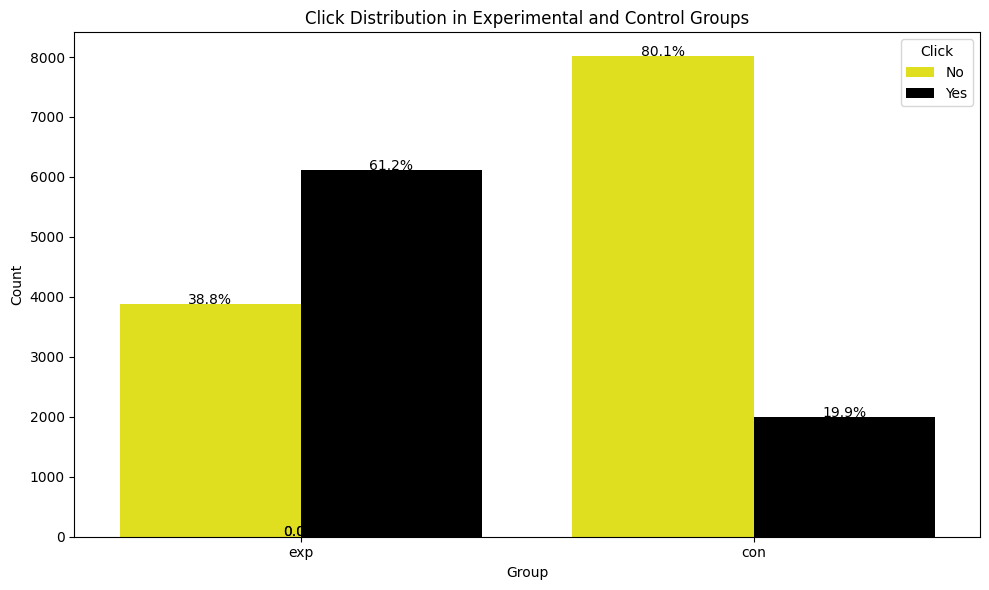

In [4]:
# Custom palette for yellow and black
palette = {0: 'yellow', 1: 'black'} # Assuming 0 is for no-click, 1 for click

# Plotting the click distribution for each group with the custom colors
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='group', hue='click', data=df_ab_test, palette=palette)
plt.title('Click Distribution in Experimental and Control Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title='Click', labels=['No', 'Yes'])

# Calculate the percentages and annotate the bars
group_counts = df_ab_test.groupby(['group']).size()
group_click_counts = df_ab_test.groupby(['group', 'click']).size().reset_index(name='count')

for p in ax.patches:
  height = p.get_height()
  # Find the group and click type for the current bar
  group = 'exp' if p.get_x() < 0.5 else 'con'
  click = 1 if p.get_x() % 1 > 0.5 else 0
  total = group_counts.loc[group]
  percentage = 100 * height / total
  ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{percentage:.1f}%', ha="center", color='black', fontsize=10)

plt.tight_layout()
plt.show()

# Parameters of the Model from Power Analysis

In [5]:
alpha = 0.05
print("Alpha: significance level is:", alpha )

delta = 0.1
print("Delta: minimum detectable effect is", delta )

Alpha: significance level is: 0.05
Delta: minimum detectable effect is 0.1


# Calculating total number of clicks per group by summing clicks

In [8]:
N_con = df_ab_test[df_ab_test["group"] == "con"].count()
N_exp = df_ab_test[df_ab_test["group"] == "exp"].count()

# Calculating the total number of clicks per group by summing 1's
X_con = df_ab_test.groupby("group")["click"].sum().loc["con"]
X_exp = df_ab_test.groupby("group")["click"].sum().loc["exp"]

# Printing this for visibility
print(df_ab_test.groupby("group")["click"].sum())
print("Number of users in Control: ", N_con)
print("Number of users in Experimental: ", N_exp)
print("Number of Clicks in Control: ", X_con)
print("Number of Clicks in Experimental: ", X_exp)

group
con    1989
exp    6116
Name: click, dtype: int64
Number of users in Control:  user_id      10000
click        10000
group        10000
timestamp        0
dtype: int64
Number of users in Experimental:  user_id      10000
click        10000
group        10000
timestamp    10000
dtype: int64
Number of Clicks in Control:  1989
Number of Clicks in Experimental:  6116


# Calculating Pooled Estimates for Clicks per Group

In [11]:
# Computing the estimate of click probability per group
p_con_hat = X_con/N_con
p_exp_hat = X_exp/N_exp
print("Click Probability in Control Group:", p_con_hat)
print("Click Probability in Experimental Group:", p_exp_hat)

# Computing the estimate of pooled clicked probability
p_pooled_hat = (X_con+X_exp)/(N_con + N_exp)
print("Pooled Click Probability:", p_pooled_hat)

Click Probability in Control Group: user_id      0.1989
click        0.1989
group        0.1989
timestamp       inf
dtype: float64
Click Probability in Experimental Group: user_id      0.6116
click        0.6116
group        0.6116
timestamp    0.6116
dtype: float64
Pooled Click Probability: user_id      0.40525
click        0.40525
group        0.40525
timestamp    0.81050
dtype: float64


# Calculating Pooled Variance

In [10]:
# Computing the estimate of pooled variance
pooled_variance = p_pooled_hat * (1-p_pooled_hat) * (1/N_con + 1/N_exp)
print("p^_pooled is: ", p_pooled_hat)
print("pooled_variance is: ", pooled_variance)

p^_pooled is:  user_id      0.40525
click        0.40525
group        0.40525
timestamp    0.81050
dtype: float64
pooled_variance is:  user_id      0.000048
click        0.000048
group        0.000048
timestamp         inf
dtype: float64


# Calculating Standard Error and Test Statistics

In [12]:
# Computing the standard error of the test
SE = np.sqrt(pooled_variance)
print("Standard Error is: ", SE)

# Computing the test statistics of Z-test
Test_stat = (p_con_hat - p_exp_hat)/SE
print("Test Statistics for 2-sample Z-test is:", Test_stat)

# Critical value of the Z-test
Z_crit = norm.ppf(1-alpha/2)
print("Z-critical value from Standard Normal distribution: ", Z_crit)

Standard Error is:  user_id      0.006943
click        0.006943
group        0.006943
timestamp         inf
dtype: float64
Test Statistics for 2-sample Z-test is: user_id     -59.441633
click       -59.441633
group       -59.441633
timestamp          NaN
dtype: float64
Z-critical value from Standard Normal distribution:  1.959963984540054


# Calculating p_values of the Z-test

In [20]:
# Calculating p_value
p_value = 2 * norm.sf(abs(Test_stat))

# Function checking the statistical significance
def is_statistical_significance(p_value, alpha):

  # Print the rounded p_value to 3 decimal places
  print(f"P-value of the 2-sample Z-test: {(p_value)}")

  # Determine statistical significance
  if p_value[0] <= alpha:
    print("There is statistical significance.")
  else:
    print("There is no statistical significance.")

is_statistical_significance(p_value, alpha)

P-value of the 2-sample Z-test: [ 0.  0.  0. nan]
There is statistical significance.


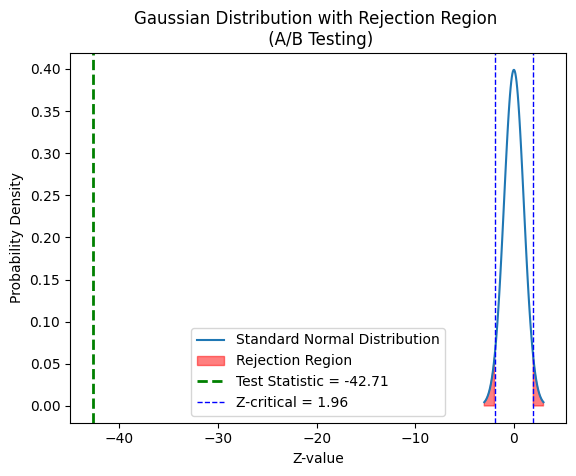

In [23]:
# Parameters for the standard normal distribution
mu = 0  # Mean
sigma = 1  # Standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)

# Plotting the standard normal distribution
plt.plot(x, y, label='Standard Normal Distribution')

# Shade the rejection region for a two-tailed test
plt.fill_between(x, y, where=(x > Z_crit) | (x < -Z_crit), color='red', alpha=0.5, label='Rejection Region')

# Adding Test Statistic
plt.axvline(Test_stat, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {Test_stat:.2f}')

# Adding Z-critical values
plt.axvline(Z_crit, color='blue', linestyle='dashed', linewidth=1, label=f'Z-critical = {Z_crit:.2f}')
plt.axvline(-Z_crit, color='blue', linestyle='dashed', linewidth=1)

# Adding labels and title
plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution with Rejection Region \n (A/B Testing)')
plt.legend()

# Show plot
plt.show()

# Calculating Confidence Interval of the test

In [24]:
# Calculate the Confidence Interval (CI) for a 2-sample Z-test
## Calculate the lower and upper bounds of the confidence interval
CI = [
    round((p_exp_hat - p_con_hat) - SE*Z_crit,3), # Lower bound
    round((p_exp_hat - p_con_hat) + SE*Z_crit,3)  # Upper bound
]

# Print the calculated confidence interval
print("Confidence Interval of the 2 sample Z-test is: ", CI)

Confidence Interval of the 2 sample Z-test is:  [user_id      0.399
click        0.399
group        0.399
timestamp     -inf
dtype: float64, user_id      0.426
click        0.426
group        0.426
timestamp      NaN
dtype: float64]


# Testing for Practical Significance in A/B Testing

In [26]:
def is_practically_significant(delta, CI_95):

  # Extract lower bound of 95% Confidence Interval
  lower_bound_CI = CI_95[0]

  # Check if the lower bound of the CI is greater than or equal to delta
  if lower_bound_CI <= delta:
    print("We have practical significance!")
    return True
  else:
    print("We don't have practical significance!")
    return False

# Example of using the function
delta = 0.05 # Assuming a 5% increase is our MDE
CI_95 = (0.04, 0.06) # Example Confidence Interval

#Call the function
significance = is_practically_significant(delta, CI_95)
print("Lower bound of 95% confidence interval is: ", CI_95[0])

We have practical significance!
Lower bound of 95% confidence interval is:  0.04
